# Part 4 project: Reconstructing the mass of the Higgs boson

In [15]:
# Import basic libraries
import copy # copy variables
import os   # manage paths
import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
import tqdm # progress bars
import atlasopenmagic as atom # ATLAS Open Data package

In [16]:
atom.get_current_release()

'2024r-pp'

In [17]:
urls_sample = atom.get_urls(345060, protocol='https')
urls_sample[:5]

['https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1',
 'https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000002.pool.root.1',
 'https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000005.pool.root.1',
 'https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000006.pool.root.1',
 'https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000007.pool.root.1']

In [18]:
filename = urls_sample[0]
filename

'https://opendata.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1'

In [19]:
tree = uproot.open({filename: "CollectionTree"})

In [20]:
electrons = ak.zip(
    {
        "pt": tree["AnalysisElectronsAuxDyn.pt"].array(),
        "eta": tree["AnalysisElectronsAuxDyn.eta"].array(),
        "phi": tree["AnalysisElectronsAuxDyn.phi"].array(),
        "m": tree["AnalysisElectronsAuxDyn.m"].array(),
        "charge": tree["AnalysisElectronsAuxDyn.charge"].array(),
    }
)

muons = ak.zip(
     {
        "pt": tree["AnalysisMuonsAuxDyn.pt"].array(),
        "eta": tree["AnalysisMuonsAuxDyn.eta"].array(),
        "phi": tree["AnalysisMuonsAuxDyn.phi"].array(),
        "charge": tree["AnalysisMuonsAuxDyn.charge"].array()
    }
)

In [21]:
events = ak.zip({"Electrons": electrons, "Muons": muons}, depth_limit=1)
events

<Array [{Electrons: [...], ...}, ..., {...}] type='50000 * {Electrons: var ...'>

In [22]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 20 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 20 * GeV) & (abs(mu.eta) < 2.47)]

In [23]:
def processed(events):
    events = copy.copy(events) # shallow copy
    
    events["Electrons"] = vector.awk(events.Electrons)
    events["Muons"] = vector.awk(events.Muons)
    
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)

    events = events[
        ( ak.num(events.Electrons) == 4 ) # exactly 4 electrons
        & ( ak.num(events.Muons) == 0 ) # exactly 0 muons
        & ( ak.sum(events.Electrons.charge, axis=-1) == 0 ) # sum electrons charge = 0
    ]
    
    return ak.to_packed(events)

In [24]:
processed_events = processed(events)

print(f'Initially we had {len(events):,} events. After the event selection we have {len(processed_events):,} events')

Initially we had 50,000 events. After the event selection we have 198 events


In [25]:
candidates = ak.combinations(processed_events.Electrons, 4)
e1, e2, e3, e4 = ak.unzip(candidates)
higgs_candidate = (e1 + e2 + e3 + e4)

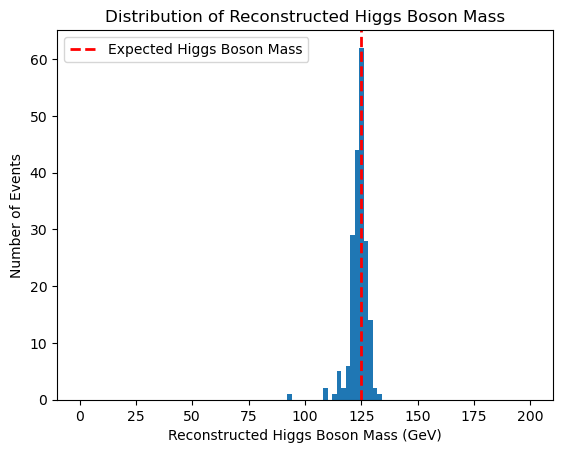

In [26]:
plt.hist(ak.flatten(higgs_candidate.mass/1000), range=(0, 200), bins = 100)
plt.axvline(125, color='r', linestyle='dashed', linewidth=2, label='Expected Higgs Boson Mass')
plt.xlabel("Reconstructed Higgs Boson Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Higgs Boson Mass")
plt.legend()
plt.show()